# DAVID MONTERO LOAIZA

# Separación de componentes con redes neuronals 
En este lab la idea es que separéis una señal en las distintas componentes que la consituyen. El caso que estudiaremos es el cielo en el rango de las microondas. La señal que nos llega es una mezcla de fondo cósmico de microondas (CMB), radiación debida al polvo térmico interestelar, y la radiación sincrotrón debida a partículas atravesando el campo magnético de nuestra Galaxia. Cuanto mejor las caractericemos, mejor las podremos estudiar, tanto para análisis cosmológicos (CMB) o para el estudio de nuestra Galaxia (sincrotrón y polvo). Así la señal que recibimos es a cada frecuencia $\nu$ es: 
\begin{equation}
S_{\nu}=S_{cmb}+S_{synch}+S_{dust}+noise
\end{equation}

Conocemos el modelo de como se comportan frecuencialmente estas componentes por separado y se puede caracterizar por 4 parámteros: Amplitud del Cmb ($A_{cmb}$), Amplitud del syncrotron e índice espectral del sincrotrón ($A_{s}$) y ($\beta_s$) y el polvo térmico con su amplitud a 353GHz $A_{d}$. 

Os vamos a dar tres data sets. Cada uno de ellos tendrá la señal (en K) con todas las componentes mezcladas más una contribución de ruido (debida a la sensibilidad del detector, cantidad de tiempo observado, etc.) y los 4 parámetros de las componentes: $A_{cmb}$, $A_{d}$ y $A_s$ y $\beta_s$ (detalles en la presentación):
* PLANCK:  9 frecuencias del satélite PLANCK de la ESA (30, 44, 70, 100, 143, 217, 353, 545, 857 GHZ).
* PLANCK + HASLAM : Añadimos un canal a muy baja frecuencia (0.408 GHz).

Los data sets los encontraréis en: SET+'_Signal_dataset.txt' y SET+'_Signal_labels.txt'

Trabajaremos con `healpy`, la parte de cargar mapas y visualizarlos está en este notebook. Podéis instalarlo con `pip install healpy`


# Ejercicio 1
   Buscaremos el mejor modelo para cada uno de los datasets y lo validaremos con uns simulación de mapas realistas
   *   **1.1.** Encuentra con una red neuronal un bueno modelo que relacione los inputs con los parámetros de las componentes para cada uno de los data sets.   
   *   **1.2.** Evalúa con una simulación independiente como de buenos son tus resultados. 
   *   **1.3.** Comenta qué parametros mejoran cuando añadimos una frecuencia más (más baja) y porqué. 

**(7 puntos)**

In [106]:
!pip install healpy

In [0]:
# Packages needed
import numpy as np
import scipy.constants as cst
import matplotlib.pyplot as plt
import healpy as hp
cmap='coolwarm'
import keras

In [0]:
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks
from keras.models import load_model

from sklearn.preprocessing import StandardScaler

In [0]:
# Data sets characteristics
def DataSet(FLAG):
    if FLAG=='PLANCK':
        freq=[30.,44.,70.,100.,143.,217.,353.,545.,857.]
        sigma=[2.8, 3.0, 4.0, 1.29, 0.55, 0.78, 2.56, 13.6, 100]
    if FLAG=='PLANCK+HASLAM':
        freq=[0.408,30.,44.,70.,100.,143.,217.,353.,545.,857.]
        sigma=[1E6,2.8, 3.0, 4.0, 1.29, 0.55, 0.78, 2.56, 13., 500]
    if FLAG=='PLANCK+HASLAM+QUIJOTE':
        freq=[0.408,11.,13.,17.,19.,30.,44.,70.,100.,143.,217.,353.,545.,857.]
        sigma=[1E6,10,10,10,10, 2.8, 3.0, 4.0, 1.29, 0.55, 0.78, 2.56, 13., 500]
    return freq,sigma

In [110]:
from google.colab import drive

drive.mount('/content/drive')

path = "/content/drive/My Drive/DL-fisica/1 CMB/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## PLANCK MODEL

In [0]:
# Read data set
SET='PLANCK'  

freq,sigma=DataSet(SET) # cargamos num de frecuencias , std del ruido, y valor maximo del synchrotron
nu_ref=freq[0]  # frecuencia donde evaluamos el synchrotron

Signal=np.loadtxt(path+SET+'_Signal_dataset.txt')   # 10000 x len(freq)
Labels=np.loadtxt(path+SET+'_Signal_labels.txt')    # 10000 x 4 params (A_cmb,A_s,beta_s,A_d)

In [0]:
scaler_PLANCK_X = StandardScaler().fit(Signal)
scaler_PLANCK_y = StandardScaler().fit(Labels)

Signal = scaler_PLANCK_X.transform(Signal)
Labels = scaler_PLANCK_y.transform(Labels)

In [25]:
# 1.1 Start obtaining your models with a NN
model_PLANCK = models.Sequential()
model_PLANCK.add(layers.Dense(20,activation="sigmoid",input_shape = (Signal.shape[1],)))
model_PLANCK.add(layers.Dense(10,activation="sigmoid"))
model_PLANCK.add(layers.Dense(Labels.shape[1]))

model_PLANCK.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 25)                250       
_________________________________________________________________
dense_8 (Dense)              (None, 10)                260       
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 44        
Total params: 554
Trainable params: 554
Non-trainable params: 0
_________________________________________________________________


In [26]:
model_PLANCK.compile(optimizer = optimizers.Adadelta(),loss="mse")
history_PLANCK = model_PLANCK.fit(Signal,Labels,batch_size = 2**8,epochs = 1000,validation_split = 0.15,callbacks=[callbacks.EarlyStopping(patience = 50)])

Train on 85000 samples, validate on 15000 samples
Epoch 1/1000
85000/85000 [==============================] - 1s 6us/step - loss: 0.7297 - val_loss: 0.5257
Epoch 2/1000
85000/85000 [==============================] - 0s 5us/step - loss: 0.4978 - val_loss: 0.4603
Epoch 3/1000
85000/85000 [==============================] - 0s 5us/step - loss: 0.3279 - val_loss: 0.2684
Epoch 4/1000
85000/85000 [==============================] - 0s 5us/step - loss: 0.2644 - val_loss: 0.2600
Epoch 5/1000
85000/85000 [==============================] - 0s 5us/step - loss: 0.2567 - val_loss: 0.2515
Epoch 6/1000
85000/85000 [==============================] - 0s 6us/step - loss: 0.2443 - val_loss: 0.2344
Epoch 7/1000
85000/85000 [==============================] - 0s 5us/step - loss: 0.2184 - val_loss: 0.2007
Epoch 8/1000
85000/85000 [==============================] - 0s 5us/step - loss: 0.1711 - val_loss: 0.1559
Epoch 9/1000
85000/85000 [==============================] - 0s 5us/step - loss: 0.1190 - val_loss: 0.1

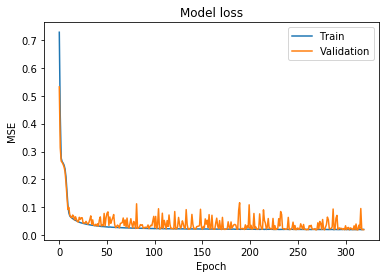

In [23]:
plt.plot(history_PLANCK.history['loss'])
plt.plot(history_PLANCK.history['val_loss'])
plt.title('Model loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [0]:
model_PLANCK.save(path+'PLANCK_model.h5')

## PLANCK+HASLAM MODEL

In [0]:
# Read data set
SET='PLANCK+HASLAM'  

freq,sigma=DataSet(SET) # cargamos num de frecuencias , std del ruido, y valor maximo del synchrotron
nu_ref=freq[0]  # frecuencia donde evaluamos el synchrotron

Signal=np.loadtxt(path+SET+'_Signal_dataset.txt')   # 10000 x len(freq)
Labels=np.loadtxt(path+SET+'_Signal_labels.txt')    # 10000 x 4 params (A_cmb,A_s,beta_s,A_d)

In [0]:
scaler_PLANCK_HASLAM_X = StandardScaler().fit(Signal)
scaler_PLANCK_HASLAM_y = StandardScaler().fit(Labels)

Signal = scaler_PLANCK_HASLAM_X.transform(Signal)
Labels = scaler_PLANCK_HASLAM_y.transform(Labels)

In [61]:
# 1.1 Start obtaining your models with a NN
model_PLANCK_HASLAM = models.Sequential()
model_PLANCK_HASLAM.add(layers.Dense(25,activation="sigmoid",input_shape = (Signal.shape[1],)))
model_PLANCK_HASLAM.add(layers.Dense(15,activation="sigmoid"))
model_PLANCK_HASLAM.add(layers.Dense(Labels.shape[1]))

model_PLANCK_HASLAM.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 25)                275       
_________________________________________________________________
dense_23 (Dense)             (None, 15)                390       
_________________________________________________________________
dense_24 (Dense)             (None, 4)                 64        
Total params: 729
Trainable params: 729
Non-trainable params: 0
_________________________________________________________________


In [62]:
model_PLANCK_HASLAM.compile(optimizer = optimizers.Adadelta(),loss="mse")
history_PLANCK_HASLAM = model_PLANCK_HASLAM.fit(Signal,Labels,batch_size = 2**8,epochs = 1000,validation_split = 0.15,callbacks=[callbacks.EarlyStopping(patience = 50)])

Train on 85000 samples, validate on 15000 samples
Epoch 1/1000
85000/85000 [==============================] - 1s 6us/step - loss: 0.7686 - val_loss: 0.5264
Epoch 2/1000
85000/85000 [==============================] - 0s 5us/step - loss: 0.4937 - val_loss: 0.4807
Epoch 3/1000
85000/85000 [==============================] - 0s 5us/step - loss: 0.4571 - val_loss: 0.4406
Epoch 4/1000
85000/85000 [==============================] - 0s 5us/step - loss: 0.4213 - val_loss: 0.4223
Epoch 5/1000
85000/85000 [==============================] - 0s 6us/step - loss: 0.4019 - val_loss: 0.4038
Epoch 6/1000
85000/85000 [==============================] - 0s 5us/step - loss: 0.3896 - val_loss: 0.3898
Epoch 7/1000
85000/85000 [==============================] - 0s 5us/step - loss: 0.3792 - val_loss: 0.3795
Epoch 8/1000
85000/85000 [==============================] - 0s 6us/step - loss: 0.3700 - val_loss: 0.3695
Epoch 9/1000
85000/85000 [==============================] - 0s 5us/step - loss: 0.3619 - val_loss: 0.3

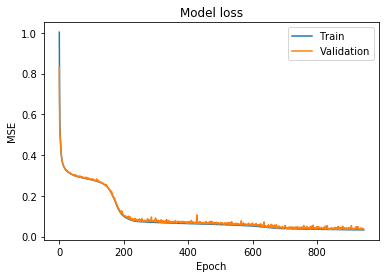

In [0]:
plt.plot(history_PLANCK_HASLAM.history['loss'])
plt.plot(history_PLANCK_HASLAM.history['val_loss'])
plt.title('Model loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [0]:
model_PLANCK_HASLAM.save(path+'PLANCK_HASLAM_model.h5')

# Ejercicio 1.2 
Con una simulación realista (Datos/Data+SET+.fits) donde sabemos cada una de las componentes, comprueba tus resultados y comenta qué efecto tiene añadir frecuencias bajas a la estimación de tus parámetros. Visualizad los mapas que obtendríais con la red y los de verdad (Datos/Params+SET+.fits) y evaluad las diferencias. 

**(3 puntos)**

In [0]:
model_PLANCK = load_model(path+'PLANCK_model.h5')
model_PLANCK_HASLAM = load_model(path+'PLANCK_HASLAM_model.h5')

## PLANCK PREDICCIÓN

In [0]:
# Cargamos con healpy los datos simulados 
SET='PLANCK'
freq,sigma=DataSet(SET) # cargamos num de frecuencias , std del ruido, y valor maximo del synchrotron
nu_ref=freq[0]  # frecuencia donde evaluamos el synchrotron

nmaps=np.arange(0,len(freq))
Datos=hp.read_map(path+'Datos/Data'+SET+'.fits',nmaps,verbose=False,dtype=np.float64)

# Los parametros que se han usado para generar estos datos son: 
True_params=hp.read_map(path+'Datos/Params'+SET+'.fits',(0,1,2,3),verbose=False,dtype=np.float64)      

# Accedemos a los mapas frecuenciales y los parametros se acceden con Datos[i], True_params[i]

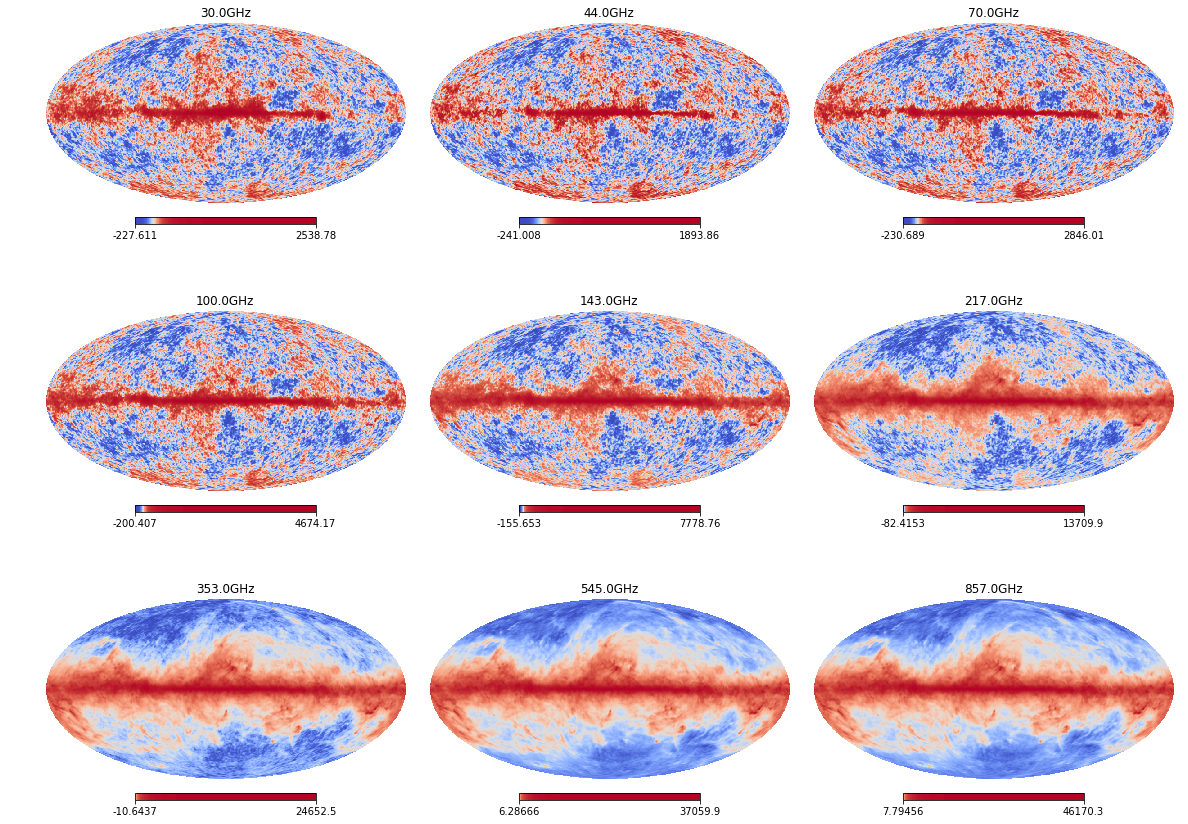

In [13]:
# Visualizamos los datos
plt.figure(0,figsize=(16,12))
if SET == 'PLANCK': n=3
if SET == 'PLANCK+HASLAM': n=4
if SET == 'PLANCK+HASLAM+QUIJOTE': n=5
for i in range(len(freq)):
    hp.mollview(Datos[i],sub=(n,3,i+1),norm='hist',title=str(freq[i])+'GHz',cmap=cmap)

In [0]:
# 1.2 Make predictions with your models and compare results
# and make a quantitative evaluation of your prediction (ex. correlation coefficient, mse,...)
Params_pred_scaled = model_PLANCK.predict(scaler_PLANCK_X.transform(Datos.T))
Params_pred = scaler_PLANCK_y.inverse_transform(Params_pred_scaled)

In [77]:
from sklearn.metrics import mean_squared_error

mse_score_PLANCK = mean_squared_error(True_params.T,Params_pred,multioutput='raw_values')
params = ['A_cmb','A_d','beta_s','B_s']

for i in range(len(params)):
  print('Parameter: '+params[i])
  print('MSE: '+ str(round(mse_score_PLANCK[i],3)))
  print('Corelation Coefficient: '+ str(round(np.corrcoef(True_params.T[:,i],Params_pred[:,i])[0,1],3)))
  print('')

Parameter: A_cmb
MSE: 24.341
Corelation Coefficient: 0.998

Parameter: A_d
MSE: 189.597
Corelation Coefficient: 0.996

Parameter: beta_s
MSE: 0.037
Corelation Coefficient: 0.12

Parameter: B_s
MSE: 260570.023
Corelation Coefficient: 0.997



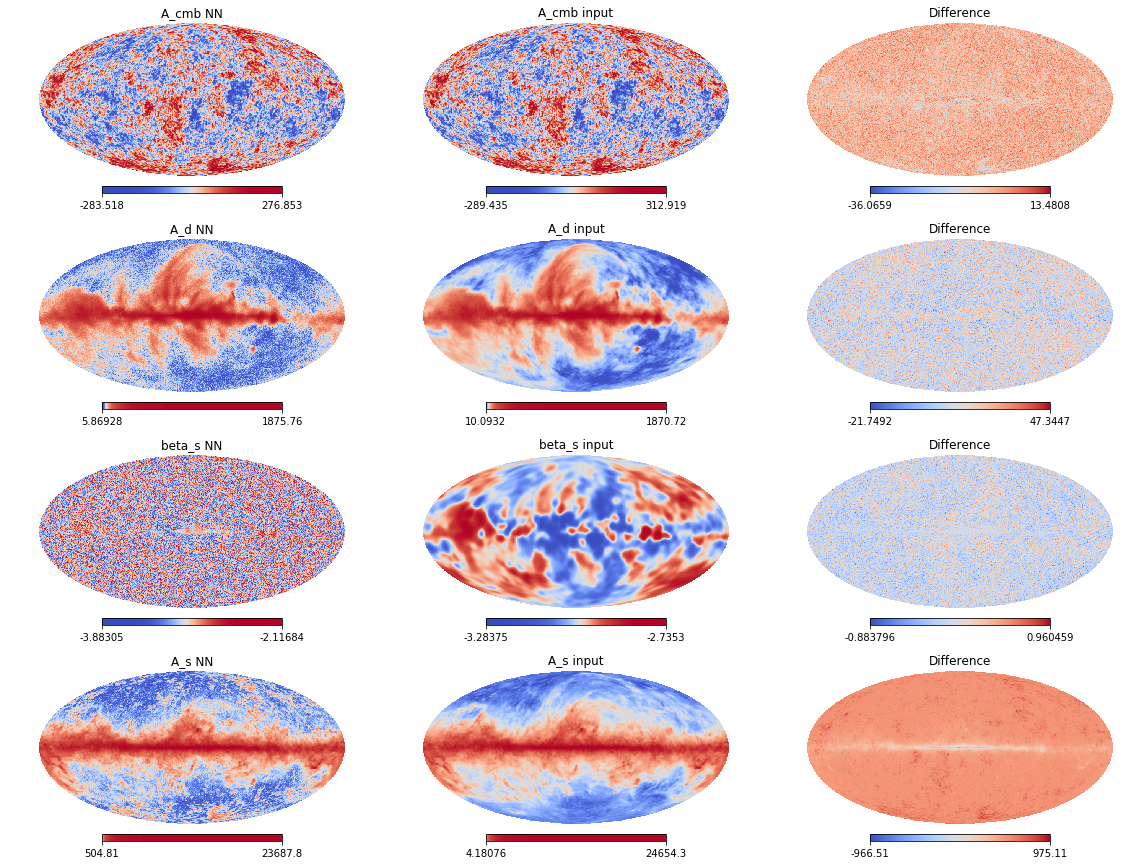

In [79]:
# Visualize the prediciton and input maps:
plt.figure(0,figsize=(16,12))
titles = ['A_cmb','A_d','beta_s','A_s']

# Example first parameter: 
# Use hp.mollview to visualize the maps and their differences:
j = 0
for i in range(4):  
  hp.mollview(Params_pred[:,i],cmap=cmap,sub=(4,3,1+j),title=titles[i]+' NN',norm='hist')
  hp.mollview(True_params[i],cmap=cmap,sub=(4,3,2+j),title=titles[i]+' input',norm='hist')
  hp.mollview(Params_pred[:,i]-True_params[i],cmap=cmap,sub=(4,3,3+j),title='Difference')
  j = j + 3

## PLANCK+HASLAM PREDICCION

In [0]:
# Cargamos con healpy los datos simulados 
SET='PLANCK+HASLAM'
freq,sigma=DataSet(SET) # cargamos num de frecuencias , std del ruido, y valor maximo del synchrotron
nu_ref=freq[0]  # frecuencia donde evaluamos el synchrotron

nmaps=np.arange(0,len(freq))
Datos=hp.read_map(path+'Datos/Data'+SET+'.fits',nmaps,verbose=False,dtype=np.float64)

# Los parametros que se han usado para generar estos datos son: 
True_params=hp.read_map(path+'Datos/Params'+SET+'.fits',(0,1,2,3),verbose=False,dtype=np.float64)      

# Accedemos a los mapas frecuenciales y los parametros se acceden con Datos[i], True_params[i]

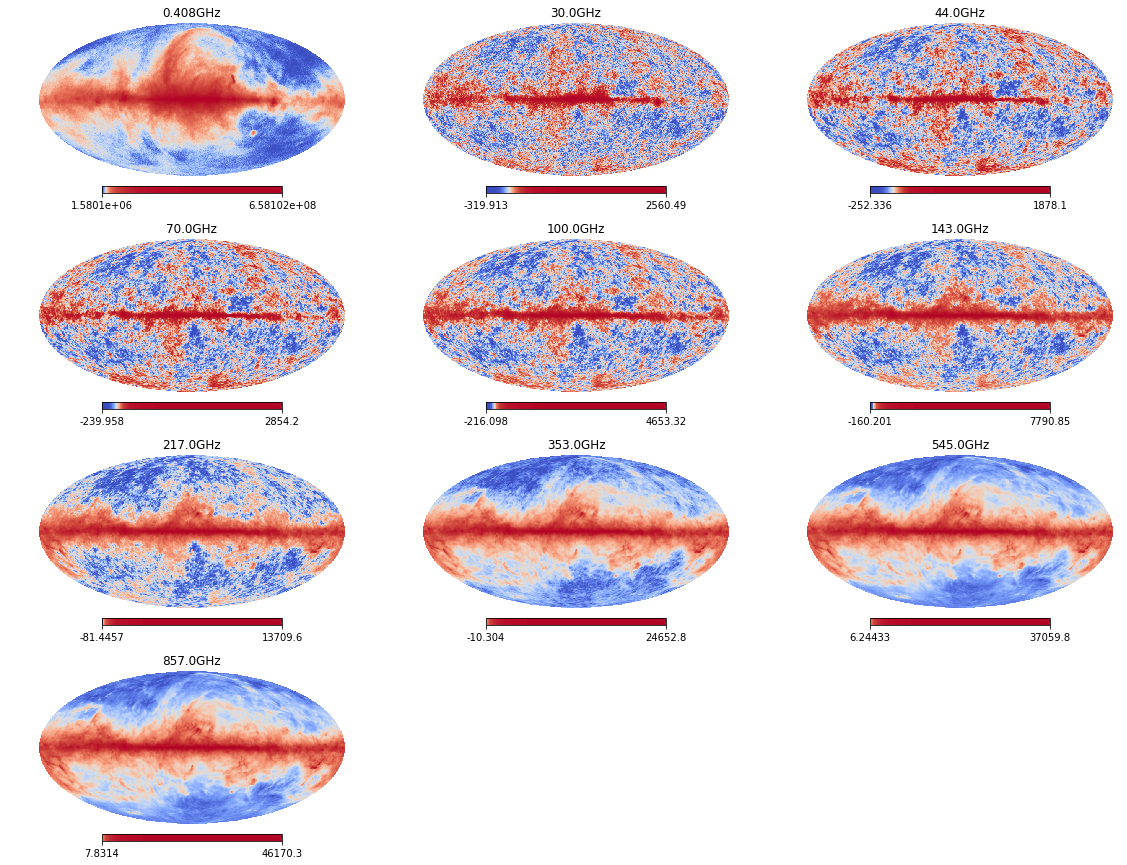

In [81]:
# Visualizamos los datos
plt.figure(0,figsize=(16,12))
if SET == 'PLANCK': n=3
if SET == 'PLANCK+HASLAM': n=4
if SET == 'PLANCK+HASLAM+QUIJOTE': n=5
for i in range(len(freq)):
    hp.mollview(Datos[i],sub=(n,3,i+1),norm='hist',title=str(freq[i])+'GHz',cmap=cmap)

In [0]:
# 1.2 Make predictions with your models and compare results
# and make a quantitative evaluation of your prediction (ex. correlation coefficient, mse,...)
Params_pred_scaled = model_PLANCK_HASLAM.predict(scaler_PLANCK_HASLAM_X.transform(Datos.T))
Params_pred = scaler_PLANCK_HASLAM_y.inverse_transform(Params_pred_scaled)

In [83]:
from sklearn.metrics import mean_squared_error

mse_score_PLANCK = mean_squared_error(True_params.T,Params_pred,multioutput='raw_values')
params = ['A_cmb','A_d','beta_s','A_s']

for i in range(len(params)):
  print('Parameter: '+params[i])
  print('MSE: '+ str(round(mse_score_PLANCK[i],3)))
  print('Corelation Coefficient: '+ str(round(np.corrcoef(True_params.T[:,i],Params_pred[:,i])[0,1],3)))
  print('')

Parameter: A_cmb
MSE: 152.49
Corelation Coefficient: 0.992

Parameter: A_d
MSE: 4.97532798327e+13
Corelation Coefficient: 0.998

Parameter: beta_s
MSE: 0.016
Corelation Coefficient: 0.48

Parameter: B_s
MSE: 48733.61
Corelation Coefficient: 0.995



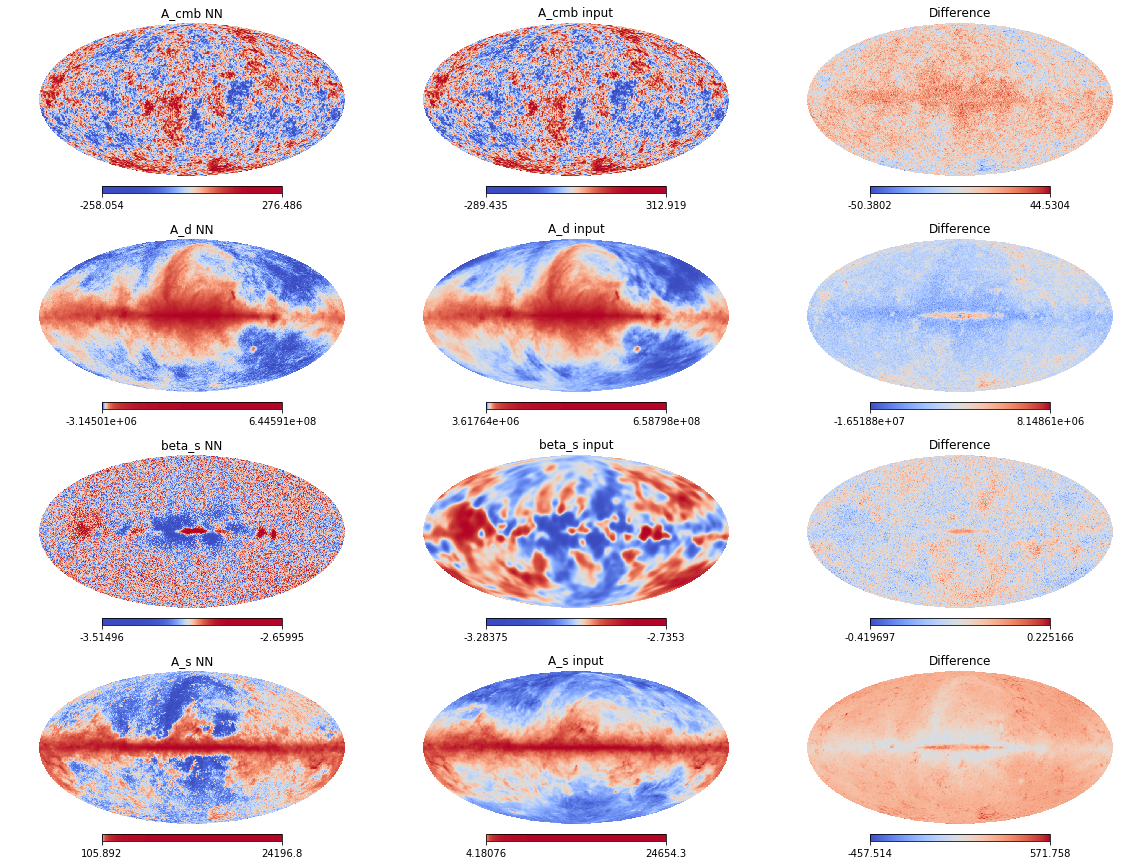

In [84]:
# Visualize the prediciton and input maps:
plt.figure(0,figsize=(16,12))
titles = ['A_cmb','A_d','beta_s','A_s']

# Example first parameter: 
# Use hp.mollview to visualize the maps and their differences:
j = 0
for i in range(4):  
  hp.mollview(Params_pred[:,i],cmap=cmap,sub=(4,3,1+j),title=titles[i]+' NN',norm='hist')
  hp.mollview(True_params[i],cmap=cmap,sub=(4,3,2+j),title=titles[i]+' input',norm='hist')
  hp.mollview(Params_pred[:,i]-True_params[i],cmap=cmap,sub=(4,3,3+j),title='Difference')
  j = j + 3

In [0]:
# 1.3  Comment what are the differences of both data sets


# Ejercicio 2. 
Para el caso PLANCK+HASLAM+QUIJOTE mandad vuestros resultados a la competición de Kaggle: https://www.kaggle.com/c/component-separation-with-nn. Podéis mandar tantos como queráis.

**(3 puntos)**

In [111]:
path = "/content/drive/My Drive/DL-fisica/1 CMB/component-separation-with-nn/"
!ls "/content/drive/My Drive/DL-fisica/1 CMB/component-separation-with-nn/"

Betas_pred_Biuse_pd.csv
DataPLANCKHASLAMQUIJOTE_CHALLENGE.fits
DataPLANCKHASLAMQUIJOTE.fits
ParamsPLANCKHASLAMQUIJOTE.fits
PLANCK_HASLAM_QUIJOTE_model.h5
PLANCKHASLAMQUIJOTE_Signal_dataset_v2.txt
PLANCKHASLAMQUIJOTE_Signal_labels_v2.txt


In [0]:
# Read data set
SET='PLANCK+HASLAM+QUIJOTE'  

freq,sigma=DataSet(SET) # cargamos num de frecuencias , std del ruido, y valor maximo del synchrotron
nu_ref=freq[0]  # frecuencia donde evaluamos el synchrotron

Signal=np.loadtxt(path+'PLANCKHASLAMQUIJOTE_Signal_dataset_v2.txt')   # 10000 x len(freq)
Labels=np.loadtxt(path+'PLANCKHASLAMQUIJOTE_Signal_labels_v2.txt')    # 10000 x 4 params (A_cmb,A_s,beta_s,A_d)

In [0]:
scaler_PLANCK_HASLAM_QUIJOTE_X = StandardScaler().fit(Signal)
scaler_PLANCK_HASLAM_QUIJOTE_y = StandardScaler().fit(Labels)

Signal = scaler_PLANCK_HASLAM_QUIJOTE_X.transform(Signal)
Labels = scaler_PLANCK_HASLAM_QUIJOTE_y.transform(Labels)

In [179]:
# 1.1 Start obtaining your models with a NN
model_PLANCK_HASLAM_QUIJOTE = models.Sequential()
model_PLANCK_HASLAM_QUIJOTE.add(layers.Dense(35,activation="sigmoid",input_shape = (Signal.shape[1],)))
model_PLANCK_HASLAM_QUIJOTE.add(layers.Dense(20,activation="sigmoid"))
model_PLANCK_HASLAM_QUIJOTE.add(layers.Dense(10,activation="sigmoid"))
model_PLANCK_HASLAM_QUIJOTE.add(layers.Dense(Labels.shape[1]))

model_PLANCK_HASLAM_QUIJOTE.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 35)                525       
_________________________________________________________________
dense_65 (Dense)             (None, 20)                720       
_________________________________________________________________
dense_66 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_67 (Dense)             (None, 4)                 44        
Total params: 1,499
Trainable params: 1,499
Non-trainable params: 0
_________________________________________________________________


In [180]:
model_PLANCK_HASLAM_QUIJOTE.compile(optimizer = optimizers.Adadelta(),loss="mse")
history_PLANCK_HASLAM_QUIJOTE = model_PLANCK_HASLAM_QUIJOTE.fit(Signal,Labels,batch_size = 2**8,epochs = 1000,validation_split = 0.15,callbacks=[callbacks.EarlyStopping(patience = 50)])

Train on 85000 samples, validate on 15000 samples
Epoch 1/1000
85000/85000 [==============================] - 1s 9us/step - loss: 0.8806 - val_loss: 0.7283
Epoch 2/1000
85000/85000 [==============================] - 1s 7us/step - loss: 0.5821 - val_loss: 0.4888
Epoch 3/1000
85000/85000 [==============================] - 1s 7us/step - loss: 0.4376 - val_loss: 0.3809
Epoch 4/1000
85000/85000 [==============================] - 1s 7us/step - loss: 0.3562 - val_loss: 0.3470
Epoch 5/1000
85000/85000 [==============================] - 1s 7us/step - loss: 0.3302 - val_loss: 0.3213
Epoch 6/1000
85000/85000 [==============================] - 1s 7us/step - loss: 0.3157 - val_loss: 0.3111
Epoch 7/1000
85000/85000 [==============================] - 1s 7us/step - loss: 0.3069 - val_loss: 0.3172
Epoch 8/1000
85000/85000 [==============================] - 1s 7us/step - loss: 0.3009 - val_loss: 0.3200
Epoch 9/1000
85000/85000 [==============================] - 1s 7us/step - loss: 0.2968 - val_loss: 0.3

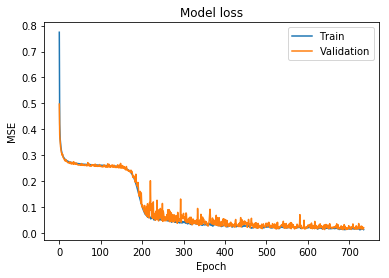

In [119]:
plt.plot(history_PLANCK_HASLAM_QUIJOTE.history['loss'])
plt.plot(history_PLANCK_HASLAM_QUIJOTE.history['val_loss'])
plt.title('Model loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [0]:
model_PLANCK_HASLAM_QUIJOTE.save(path+'PLANCK_HASLAM_QUIJOTE_model.h5')

In [0]:
# Cargamos con healpy los datos simulados 
SET='PLANCK+HASLAM+QUIJOTE'
freq,sigma=DataSet(SET) # cargamos num de frecuencias , std del ruido, y valor maximo del synchrotron
nu_ref=freq[0]  # frecuencia donde evaluamos el synchrotron

nmaps=np.arange(0,len(freq))
Datos=hp.read_map(path+'DataPLANCKHASLAMQUIJOTE.fits',nmaps,verbose=False,dtype=np.float64)
Datos_kaggle=hp.read_map(path+'DataPLANCKHASLAMQUIJOTE_CHALLENGE.fits',nmaps,verbose=False,dtype=np.float64)

# Los parametros que se han usado para generar estos datos son: 
True_params=hp.read_map(path+'ParamsPLANCKHASLAMQUIJOTE.fits',(0,1,2,3),verbose=False,dtype=np.float64)      

# Accedemos a los mapas frecuenciales y los parametros se acceden con Datos[i], True_params[i]

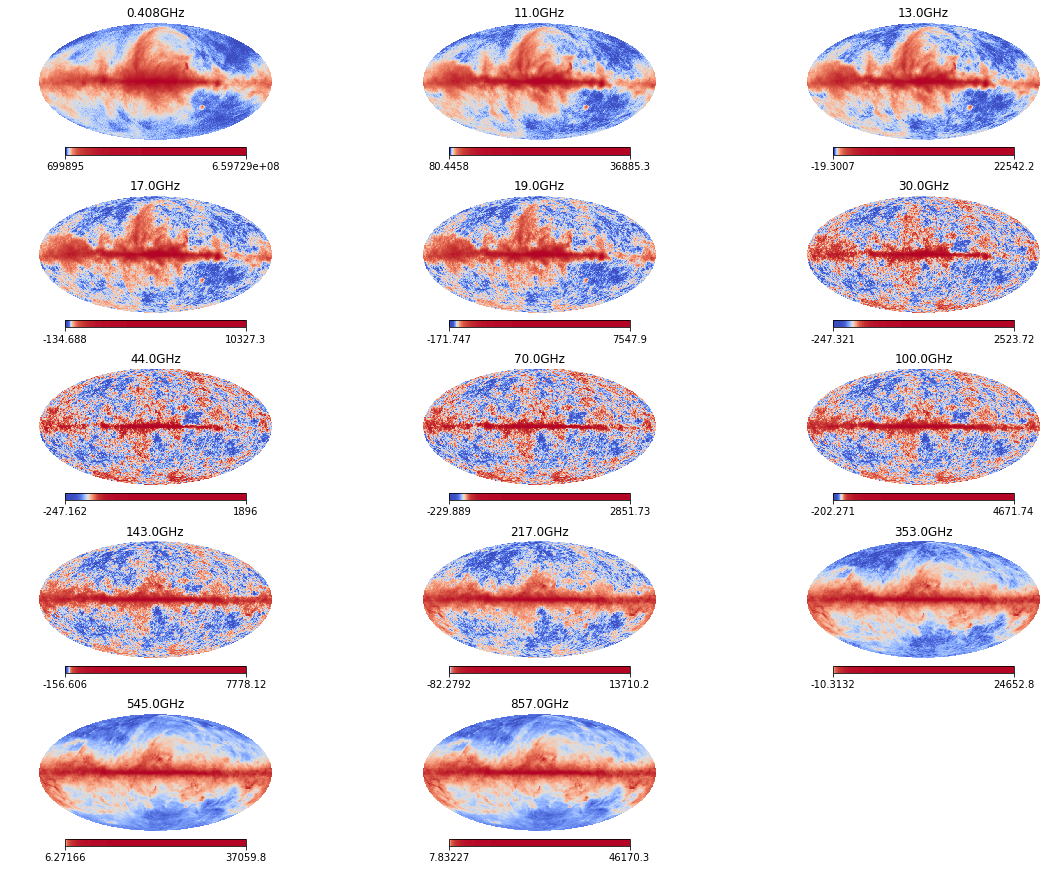

In [102]:
# Visualizamos los datos
plt.figure(0,figsize=(16,12))
if SET == 'PLANCK': n=3
if SET == 'PLANCK+HASLAM': n=4
if SET == 'PLANCK+HASLAM+QUIJOTE': n=5
for i in range(len(freq)):
    hp.mollview(Datos[i],sub=(n,3,i+1),norm='hist',title=str(freq[i])+'GHz',cmap=cmap)

In [0]:
# 1.2 Make predictions with your models and compare results
# and make a quantitative evaluation of your prediction (ex. correlation coefficient, mse,...)
Params_pred_scaled = model_PLANCK_HASLAM_QUIJOTE.predict(scaler_PLANCK_HASLAM_QUIJOTE_X.transform(Datos.T))
Params_pred = scaler_PLANCK_HASLAM_QUIJOTE_y.inverse_transform(Params_pred_scaled)

In [182]:
from sklearn.metrics import mean_squared_error

mse_score_PLANCK = mean_squared_error(True_params.T,Params_pred,multioutput='raw_values')
params = ['A_cmb','A_d','beta_s','A_s']

for i in range(len(params)):
  print('Parameter: '+params[i])
  print('MSE: '+ str(round(mse_score_PLANCK[i],3)))
  print('Corelation Coefficient: '+ str(round(np.corrcoef(True_params.T[:,i],Params_pred[:,i])[0,1],3)))
  print('')

Parameter: A_cmb
MSE: 25.63
Corelation Coefficient: 0.999

Parameter: A_d
MSE: 8.45671720379e+12
Corelation Coefficient: 0.998

Parameter: beta_s
MSE: 0.001
Corelation Coefficient: 0.886

Parameter: A_s
MSE: 12810.684
Corelation Coefficient: 0.998



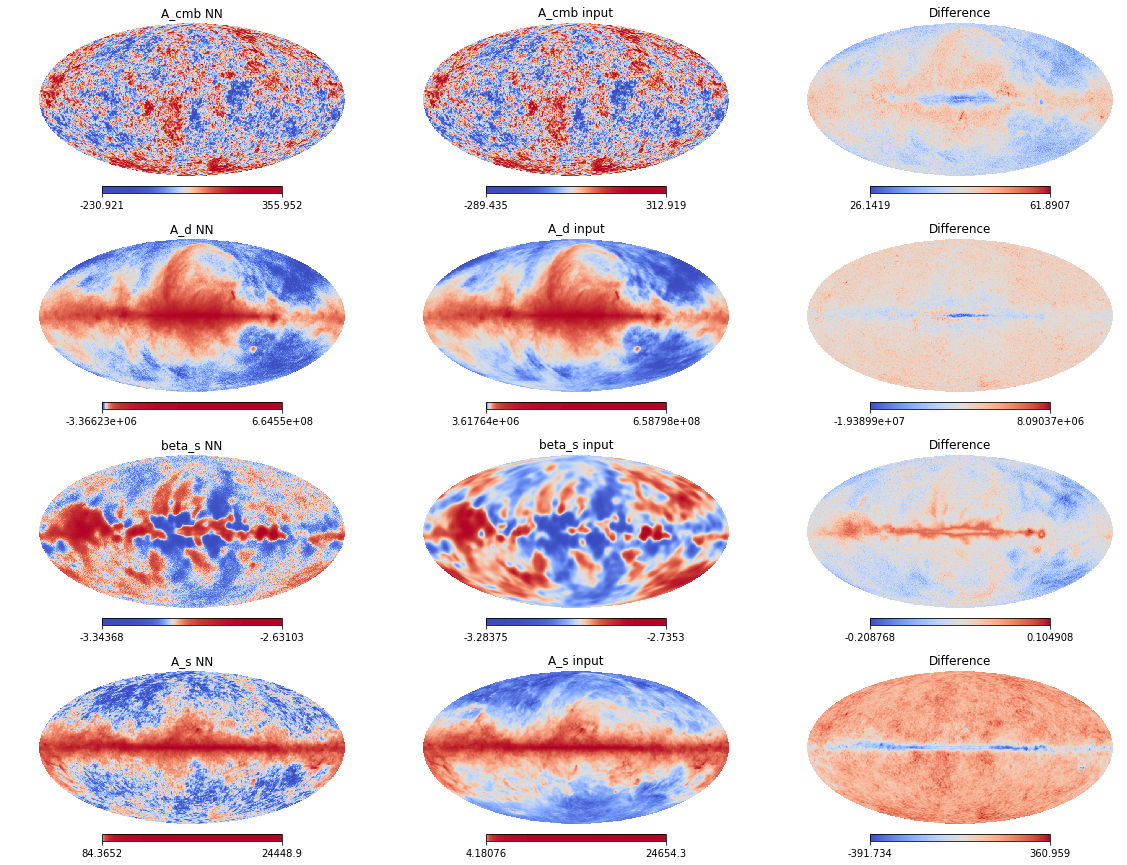

In [130]:
# Visualize the prediciton and input maps:
plt.figure(0,figsize=(16,12))
titles = ['A_cmb','A_d','beta_s','A_s']

# Example first parameter: 
# Use hp.mollview to visualize the maps and their differences:
j = 0
for i in range(4):  
  hp.mollview(Params_pred[:,i],cmap=cmap,sub=(4,3,1+j),title=titles[i]+' NN',norm='hist')
  hp.mollview(True_params[i],cmap=cmap,sub=(4,3,2+j),title=titles[i]+' input',norm='hist')
  hp.mollview(Params_pred[:,i]-True_params[i],cmap=cmap,sub=(4,3,3+j),title='Difference')
  j = j + 3

In [0]:
# 1.2 Make predictions with your models and compare results
# and make a quantitative evaluation of your prediction (ex. correlation coefficient, mse,...)
Params_pred_scaled = model_PLANCK_HASLAM_QUIJOTE.predict(scaler_PLANCK_HASLAM_QUIJOTE_X.transform(Datos_kaggle.T))
Params_pred = scaler_PLANCK_HASLAM_QUIJOTE_y.inverse_transform(Params_pred_scaled)
Params_pred = pd.DataFrame(Params_pred).reset_index()
Params_pred.columns = ["id","A_cmd","Ad","betas","As"]
Params_pred[['id','betas']].to_csv(path+"BETAS_PRED_DAVID_MONTERO_5.csv",header = True,index = False)